# Time Series Analysis



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np

In [4]:
RealGDPJP = pd.read_csv('/content/drive/MyDrive/Advance Macro Economics/JPNRGDPEXP.csv', header=0, index_col=0)
type(RealGDPJP)

pandas.core.frame.DataFrame

In [5]:
dti = pd.date_range("1994-01-01", periods=len(RealGDPJP),
freq="QS") #Q: quarterly , S: start
RealGDPJP.set_index(dti, inplace=True)
type(RealGDPJP.index)

pandas.core.indexes.datetimes.DatetimeIndex

(8766.0, 18536.0)

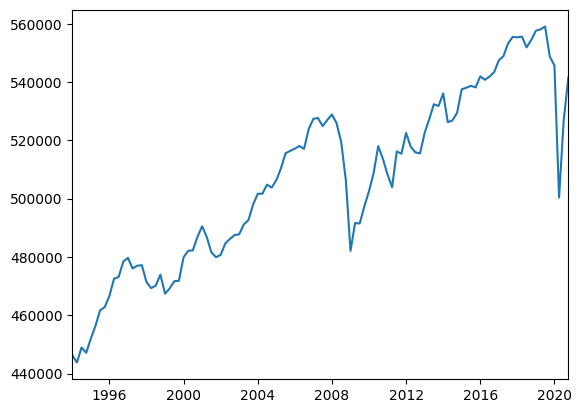

In [6]:
from matplotlib import pyplot as plt
plt.plot(RealGDPJP.iloc[:, 0])
plt.xlim(dti[0], dti[-1])

## AR model
Estimate an AR model using Conditional Maximum Likelihood (OLS)

In [7]:
import statsmodels.api as sm

In [9]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [12]:
model = AutoReg(np.log(RealGDPJP.iloc[:, 0]), 1)
result = model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:             JPNRGDPEXP   No. Observations:                  108
Model:                     AutoReg(1)   Log Likelihood                 307.424
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Wed, 05 Jun 2024   AIC                           -608.849
Time:                        02:26:58   BIC                           -600.830
Sample:                    04-01-1994   HQIC                          -605.598
                         - 10-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5465      0.290      1.883      0.060      -0.022       1.116
JPNRGDPEXP.L1     0.9585      0.022     43.363      0.000       0.915       1.002
                                    Root

We can select the lag order of AR model using AIC or BIC.

In [13]:
select = ar_select_order(np.log(RealGDPJP.iloc[:, 0]), 13, ic='aic')
select.ar_lags
result = select.model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:             JPNRGDPEXP   No. Observations:                  108
Model:                     AutoReg(1)   Log Likelihood                 307.424
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Wed, 05 Jun 2024   AIC                           -608.849
Time:                        02:29:37   BIC                           -600.830
Sample:                    04-01-1994   HQIC                          -605.598
                         - 10-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5465      0.290      1.883      0.060      -0.022       1.116
JPNRGDPEXP.L1     0.9585      0.022     43.363      0.000       0.915       1.002
                                    Root

### Impulse Response Function

<ipython-input-16-b453cfdaad7a>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predict_result[0] = resid
<ipython-input-16-b453cfdaad7a>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_x[0] = resid
<ipython-input-16-b453cfdaad7a>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predict_result[0] = resid
<ipython-input-16-b453cfdaad7a>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_x[0] = resid


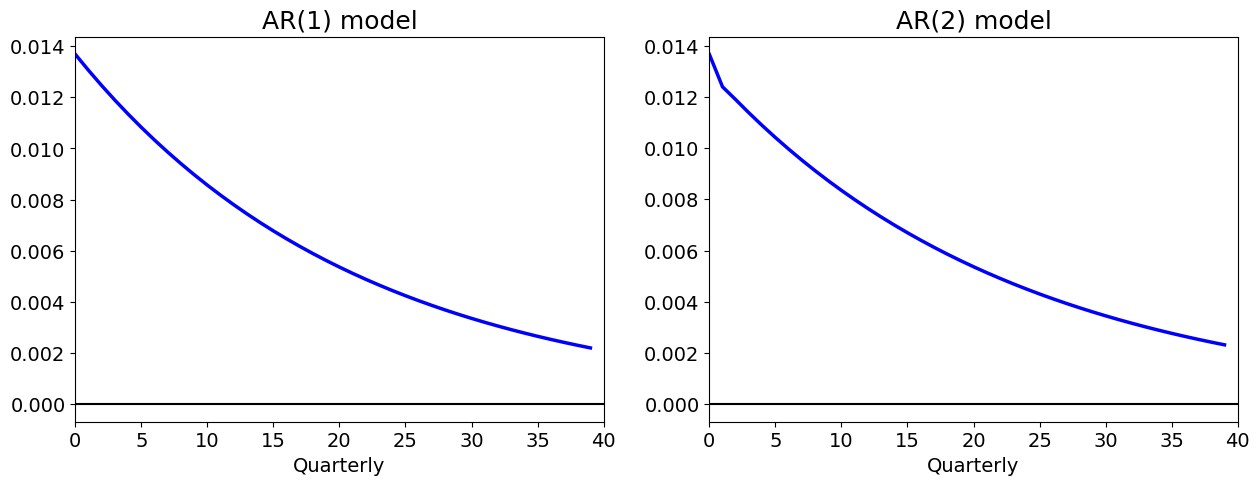

In [16]:
from sklearn.linear_model import LinearRegression
L = 2
MAX_H = 40
data = np.log(RealGDPJP.iloc[:, 0])
ssize = len(data)
plt.figure(figsize=(15, 5))
predict_result = np.zeros(MAX_H)
for l in range(1, L+1, 1):
  train_x , train_y = pd.DataFrame(), pd.DataFrame(data[L:ssize])
  for ll in range(1, l + 1):
    train_x_lagged = pd.DataFrame(data[L - ll : L - ll + len(train_y)].to_numpy())
    train_x = pd.concat([train_x , train_x_lagged], axis=1)
  model = LinearRegression()
  model.fit(train_x , train_y)
  y_hat = model.predict(train_x)
  resid = np.std(y_hat - train_y)
  predict_result[0] = resid
  test_x = np.zeros(l)
  test_x[0] = resid
  for h in range(1, MAX_H , 1):
    forecast = np.sum(test_x*model.coef_)
    test_x[1:] = test_x[:-1]
    test_x[0] = forecast
    predict_result[h] = forecast
  ar_impulse = pd.DataFrame(predict_result).to_numpy()
  # Graph
  plt.subplot(1, 2, l)
  plt.plot(ar_impulse , linestyle='solid', color='blue',
  linewidth=2.5)
  plt.title('AR(%i) model' %l, fontsize=18)
  plt.hlines([0], 0, MAX_H , color='black', linestyle='solid')
  plt.xlabel("Quarterly", fontsize=14)
  plt.tick_params(labelsize=14)
  plt.xlim(0, MAX_H)

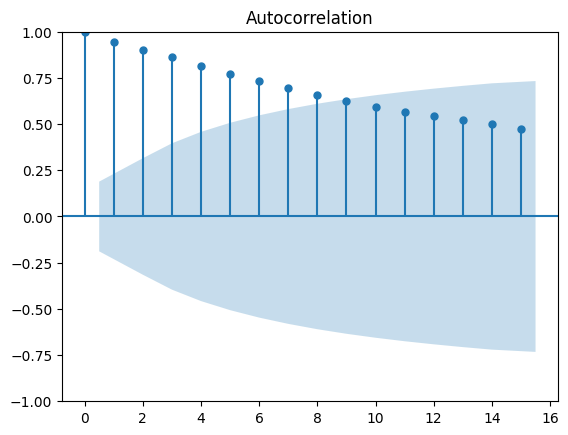

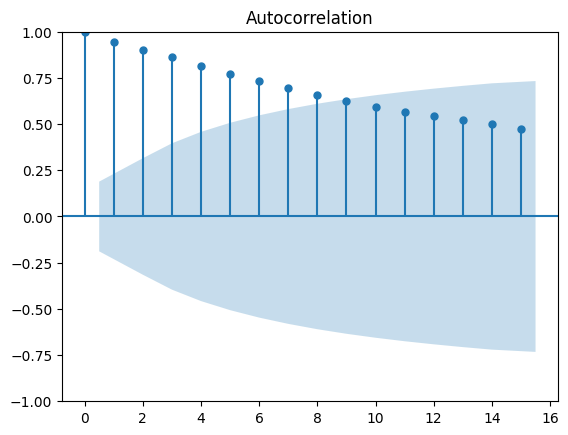

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.log(RealGDPJP.iloc[:, 0]), lags=15, alpha=.05)

## Var Model

In [18]:
from statsmodels.tsa.api import VAR
df_var = pd.read_csv("/content/drive/MyDrive/Advance Macro Economics/data_VAR1.csv")

### Lag Selection and Estimation

In [19]:
model = VAR(df_var[['FFrate','Infl']])
result = model.fit(maxlags=13, ic='bic')
lag_order = result.k_ar
print(f"lag order: {lag_order}")
print(result.summary())

lag order: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jun, 2024
Time:                     02:35:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.25880
Nobs:                     235.000    HQIC:                  -2.45210
Log likelihood:          -341.437    FPE:                  0.0755822
AIC:                     -2.58267    Det(Omega_mle):       0.0689739
--------------------------------------------------------------------
Results for equation FFrate
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.164924         0.092900            1.775           0.076
L1.FFrate         1.445780         0.067838           21.312           0.000
L1.Infl          -0.828914         0.136126           -6.089  

### Granger Causality Test

In [20]:
# F statistics (confidence level = 0.05)
# H0: No Granger causality from inflation rate to Federal fund rate
GrangerTest1 = result.test_causality('FFrate', 'Infl', kind='f', signif=0.05)
print(GrangerTest1.summary())

# H0: No Granger causality from Federal fund rate toinflation rate
GrangerTest2 = result.test_causality('Infl', 'FFrate', kind='f', signif=0.05)
print(GrangerTest2.summary())

Granger causality F-test. H_0: Infl does not Granger-cause FFrate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         10.91          2.234   0.000 (5, 448)
----------------------------------------------
Granger causality F-test. H_0: FFrate does not Granger-cause Infl. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         15.20          2.234   0.000 (5, 448)
----------------------------------------------


### Orthogonalized Impulse Response Functions

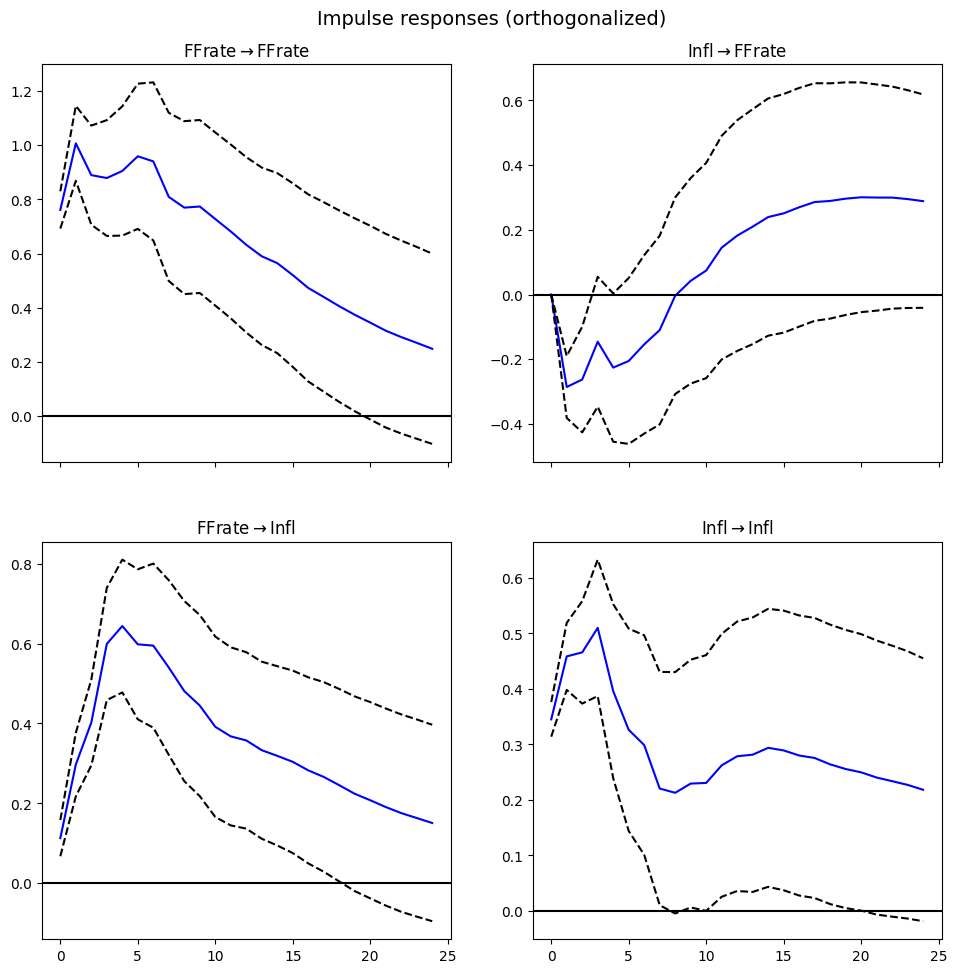

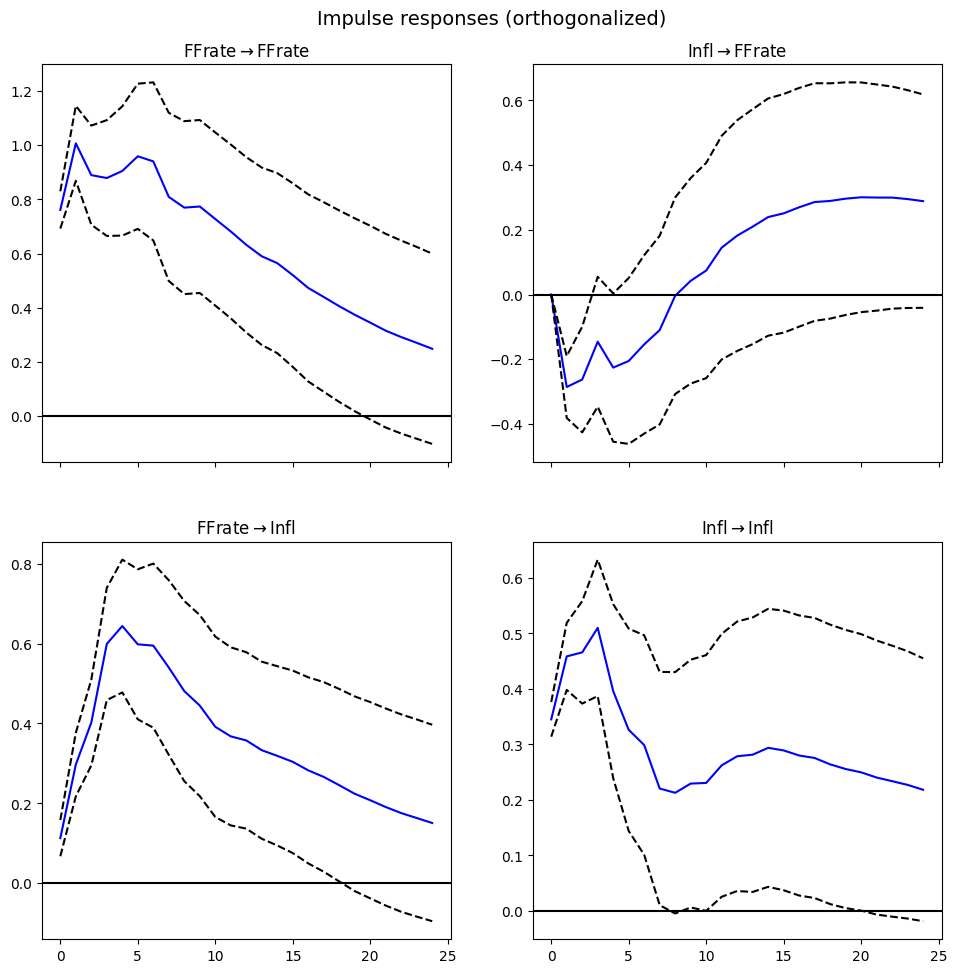

In [21]:
irf = result.irf(periods=24)
irf.plot(orth=True, signif=0.05)